# <img src="https://img.icons8.com/dusk/64/000000/mind-map.png" style="height:50px;display:inline"> Data Exploratiom and Preprocessing
-----

**Data Source** : <a href="https://zenodo.org/records/1188976">https://zenodo.org/records/1188976</a>

- The filenames are structured as Modality-VocalChannel-Emotion-Intensity-Statement-Repetition-Actor, e.g., 02-01-06-01-02-01-12.mp4. Key parts for classification:

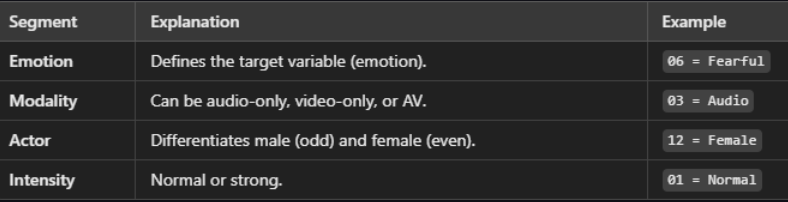

In [27]:
# -Needed Libiraries

import os
import pandas as pd
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [28]:
# -Third Part in File Name detect Motion -
emotion_mapping = {
     "01": "neutral",
     "02": "calm",
     "03": "happy",
     "04": "sad",
     "05": "angry",
     "06": "fearful",
     "07": "disgust",
     "08": "surprised"
}


### Parse filenames and create a DataFrame
----

In [29]:
def parse_filenames(base_dir , emotion_mapping):
     data = []
     for root, _, files in os.walk(base_dir):
          for file in files:
               if file.endswith(".wav"):
                    relative_path = os.path.relpath(os.path.join(root, file),base_dir)
                    parts = file.split('-')
                    emotion = emotion_mapping[parts[2]]
                    intensity = "strong" if parts[3] == "02" else "normal"
                    actor_id = int(parts[6].split('.')[0])
                    gender = "male" if actor_id % 2 != 0 else "female"
     
                    data.append({
                    "filename": relative_path,
                    "emotion": emotion,
                    "intensity": intensity,
                    "gender": gender,
                    "actor_id": actor_id
                    })
     return pd.DataFrame(data)


In [30]:
audio_dir = r"D:\FCIS_LV4\FCISLV4\Machine Learning\Project\Actors"
metadata = parse_filenames(audio_dir , emotion_mapping)



### Step 1: Load and Examine the metadata Dataset
------

In [31]:
# Display a sample of metadata
print("Metadata Sample:")
display(metadata.head())

Metadata Sample:


,filename,emotion,intensity,gender,actor_id
0,Actor_01\03-01-01-01-01-01-01.wav,neutral,normal,male,1
1,Actor_01\03-01-01-01-01-02-01.wav,neutral,normal,male,1
2,Actor_01\03-01-01-01-02-01-01.wav,neutral,normal,male,1
3,Actor_01\03-01-01-01-02-02-01.wav,neutral,normal,male,1
4,Actor_01\03-01-02-01-01-01-01.wav,calm,normal,male,1


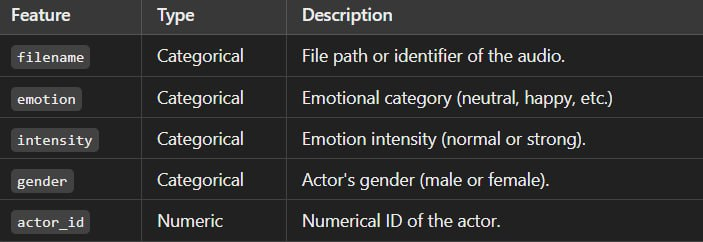

-----

#### ***Descripes the The data Rows and columns as we have 1440 row and total 5 columns With No null value***

In [32]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   1440 non-null   object
 1   emotion    1440 non-null   object
 2   intensity  1440 non-null   object
 3   gender     1440 non-null   object
 4   actor_id   1440 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 56.4+ KB


- ***We Donot Have null values***

In [33]:
metadata.isnull().sum()

filename     0
emotion      0
intensity    0
gender       0
actor_id     0
dtype: int64

### Step 3: File Name and Label Analysis
-----

***We Check unique Values We Have Unique Emotion Labels: 8***
- Label Categories: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']
- and Unique Intensity Labels: 2
- Label Categories: ['normal' 'strong']
- Unique gender Labels: 2
- Label Categories: ['male' 'female']

In [34]:
# Check if any filenames are duplicated
duplicate_files = metadata['filename'].duplicated().sum()
print(f"Number of duplicate filenames: {duplicate_files}")

# 1. Analyze Labels
labels = metadata['emotion']  
print("\nLabel Overview:")
print(f"Unique Emotion Labels: {labels.nunique()}")
print(f"Label Categories: {labels.unique()}")

labels = metadata['intensity']  
print("\nLabel Overview:")
print(f"Unique Intensity Labels: {labels.nunique()}")
print(f"Label Categories: {labels.unique()}")

labels = metadata['gender']  
print("\nLabel Overview:")
print(f"Unique gender Labels: {labels.nunique()}")
print(f"Label Categories: {labels.unique()}")


Number of duplicate filenames: 0

Label Overview:
Unique Emotion Labels: 8
Label Categories: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']

Label Overview:
Unique Intensity Labels: 2
Label Categories: ['normal' 'strong']

Label Overview:
Unique gender Labels: 2
Label Categories: ['male' 'female']


# PreProcessing
-----
##### Convert emotion labels into numerical format for machine learning models:
- If target labels (emotions) were categorical, they were likely converted to numerical values
- fit_transform converts each unique emotion into a corresponding number

----
### Label Encoding 
***to convert from Category to numeric value for calculations***

### Gender

In [35]:
# 2. Encode Labels
labels = metadata['gender']  
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [36]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Encoding Mapping:")
print(label_mapping)


Label Encoding Mapping:
{'female': 0, 'male': 1}


In [37]:
encoded_data = pd.DataFrame({
     "Original Labels": labels,
     "Encoded Labels": labels_encoded
})
print("\nSample of Original vs Encoded Labels:")
display(encoded_data)


Sample of Original vs Encoded Labels:


,Original Labels,Encoded Labels
0,male,1
1,male,1
2,male,1
3,male,1
4,male,1
...,...,...
1435,female,0
1436,female,0
1437,female,0
1438,female,0


### Emotion

In [38]:
labels = metadata['emotion']  
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [39]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Encoding Mapping:")
print(label_mapping)


Label Encoding Mapping:
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [40]:
encoded_data = pd.DataFrame({
     "Original Labels": labels,
     "Encoded Labels": labels_encoded
})
print("\nSample of Original vs Encoded Labels:")
display(encoded_data)


Sample of Original vs Encoded Labels:


,Original Labels,Encoded Labels
0,neutral,5
1,neutral,5
2,neutral,5
3,neutral,5
4,calm,1
...,...,...
1435,surprised,7
1436,surprised,7
1437,surprised,7
1438,surprised,7


#### Null Value Check in Metadata
----
- **isnull used to check There is no null values in the data**

In [41]:
print("\nNull Value Check in Metadata:")
print(metadata.isnull().sum())


Null Value Check in Metadata:
filename     0
emotion      0
intensity    0
gender       0
actor_id     0
dtype: int64


### MFCC
----

***Using librosa, extract MFCCs (Mel-Frequency Cepstral Coefficients), which are widely used in audio classification tasks:***

In [42]:
# Function to extract MFCC features
def extract_features(file_path):
     try:
          audio, sr = librosa.load(file_path, sr=None)
          # Compute MFCC features (13 coefficients)
          mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
          return np.mean(mfccs.T, axis=0)  # Average over time
     except Exception as e:
          print(f"Error processing {file_path}: {e}")
          return None
     
# Process all files and attach features to metadata
def process_audio_files(metadata, base_dir):
     features = []
     for _, row in metadata.iterrows():
          file_path = os.path.join(base_dir, row["filename"])
          mfcc = extract_features(file_path)
          if mfcc is not None:
               features.append(mfcc)
     return np.array(features)

In [17]:
# Extract features
features = process_audio_files(metadata, audio_dir)

# Ensure labels align with features
labels = metadata["emotion"].values

labels

array(['neutral', 'neutral', 'neutral', ..., 'surprised', 'surprised',
       'surprised'], dtype=object)

### Combine features and labels into a single DataFrame

In [18]:

features_df = pd.DataFrame(features, columns=[f"mfcc_{i}" for i in range(features.shape[1])])
features_df["emotion"] = labels_encoded

csv_path = "D:\FCIS_LV4\FCISLV4\Machine Learning\Project\processed_audio_features.csv"
features_df.to_csv(csv_path, index=False)
print(f"Features saved to {csv_path}")

Features saved to D:\FCIS_LV4\FCISLV4\Machine Learning\Project\processed_audio_features.csv


In [19]:
data = pd.read_csv("processed_audio_features.csv")

print(data.head())

      mfcc_0     mfcc_1    mfcc_2     mfcc_3    mfcc_4    mfcc_5    mfcc_6  \
0 -693.49700  50.064392  0.571451  14.329966  3.336370 -2.540720 -4.057909   
1 -683.34680  48.889260 -1.683444  19.183002  1.969590 -0.799272 -4.795028   
2 -677.80810  51.402702 -0.009546  14.301585  0.767162 -0.238382 -6.169593   
3 -674.01917  50.680557  1.878226  14.295362  3.069178  1.584900 -7.450740   
4 -709.05680  55.734306  2.668310  16.362572  3.344781 -1.124848 -5.818393   

      mfcc_7    mfcc_8    mfcc_9   mfcc_10   mfcc_11   mfcc_12  emotion  
0 -10.711999 -7.294139  1.740189 -4.190643  1.954662 -5.247894        5  
1 -12.342567 -5.447438  2.112868 -4.214960  1.387855 -5.127993        5  
2 -10.741851 -7.621189  1.282321 -3.815087  1.957352 -5.738728        5  
3 -11.413989 -7.078836  1.719448 -2.579532  0.674678 -4.834568        5  
4  -8.999178 -9.009146  1.838563 -4.596883  0.866339 -5.265192        1  


-------
- #### Basic Information

In [20]:
print("Dataset Overview:")
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")
print("\nSample of Data:")
display(data.head())


Dataset Overview:
Number of Rows: 1440
Number of Columns: 14

Sample of Data:


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,emotion
0,-693.49700,50.064392,0.571451,14.329966,3.336370,-2.540720,-4.057909,-10.711999,-7.294139,1.740189,-4.190643,1.954662,-5.247894,5
1,-683.34680,48.889260,-1.683444,19.183002,1.969590,-0.799272,-4.795028,-12.342567,-5.447438,2.112868,-4.214960,1.387855,-5.127993,5
2,-677.80810,51.402702,-0.009546,14.301585,0.767162,-0.238382,-6.169593,-10.741851,-7.621189,1.282321,-3.815087,1.957352,-5.738728,5
3,-674.01917,50.680557,1.878226,14.295362,3.069178,1.584900,-7.450740,-11.413989,-7.078836,1.719448,-2.579532,0.674678,-4.834568,5
4,-709.05680,55.734306,2.668310,16.362572,3.344781,-1.124848,-5.818393,-8.999178,-9.009146,1.838563,-4.596883,0.866339,-5.265192,1


------
- #### Feature Description

In [21]:
print("\nFeature Description:")
feature_info = pd.DataFrame({
     "Data Type": data.dtypes,
     "Unique Values": data.nunique(),
     "Daplicated Data": data.duplicated(),
     "Null Count": data.isnull().sum(),
     "Null Percentage": (data.isnull().sum() / len(data)) * 100
})
display(feature_info)


Feature Description:


,Data Type,Unique Values,Daplicated Data,Null Count,Null Percentage
0,NaN,NaN,False,NaN,NaN
1,NaN,NaN,False,NaN,NaN
2,NaN,NaN,False,NaN,NaN
3,NaN,NaN,False,NaN,NaN
4,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...
mfcc_5,float64,1439.0,NaN,0.0,0.0
mfcc_6,float64,1439.0,NaN,0.0,0.0
mfcc_7,float64,1439.0,NaN,0.0,0.0
mfcc_8,float64,1439.0,NaN,0.0,0.0


------
- #### Statistical Summary

In [22]:
print("\nStatistical Summary (Numerical Features):")
display(data.describe())


Statistical Summary (Numerical Features):


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,emotion
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,-575.622976,42.897555,-6.707510,9.007800,-5.357793,-4.580063,-10.823300,-8.306261,-4.079534,-2.444949,-5.009308,-0.799237,-2.810671,3.400000
std,100.789130,16.464045,12.597891,8.913506,8.636962,6.973447,6.378956,5.127278,4.680947,4.885597,4.359069,4.416651,4.070239,2.333191
min,-839.964400,-16.015596,-53.133260,-16.496914,-32.146606,-29.106770,-28.155966,-28.846071,-25.827690,-15.973001,-18.981539,-13.620789,-13.267852,0.000000
25%,-650.994490,31.994801,-14.772826,2.473095,-11.246207,-9.181316,-15.539217,-11.641354,-7.219857,-5.957290,-7.794733,-3.521307,-5.419819,1.000000
50%,-581.760930,43.208192,-6.419664,8.314690,-5.374804,-4.844166,-11.291882,-8.301350,-4.127372,-2.533584,-5.218966,-0.986755,-2.961069,3.000000
75%,-512.104433,54.708827,1.832005,15.789184,1.012130,-0.215419,-5.982442,-4.825388,-1.101363,1.132741,-2.576429,1.525721,-0.778464,6.000000
max,-288.753540,92.167590,29.495275,34.228040,16.194430,16.625406,6.201122,8.123950,21.711050,17.267515,19.575842,20.691628,18.533300,7.000000


-----
- #### Null value handling in feature information

In [23]:
print("\nHandling Null Values:")
null_columns = feature_info[feature_info["Null Count"] > 0]
if null_columns.empty:
     print("No missing values detected.")
else:
     print("Missing Value Summary:")
     display(null_columns)
     print("\nSuggested Actions: Fill or drop null values based on feature importance.")


Handling Null Values:
No missing values detected.


------
- #### Correlation Analysis


Correlation Analysis (Numerical Features):


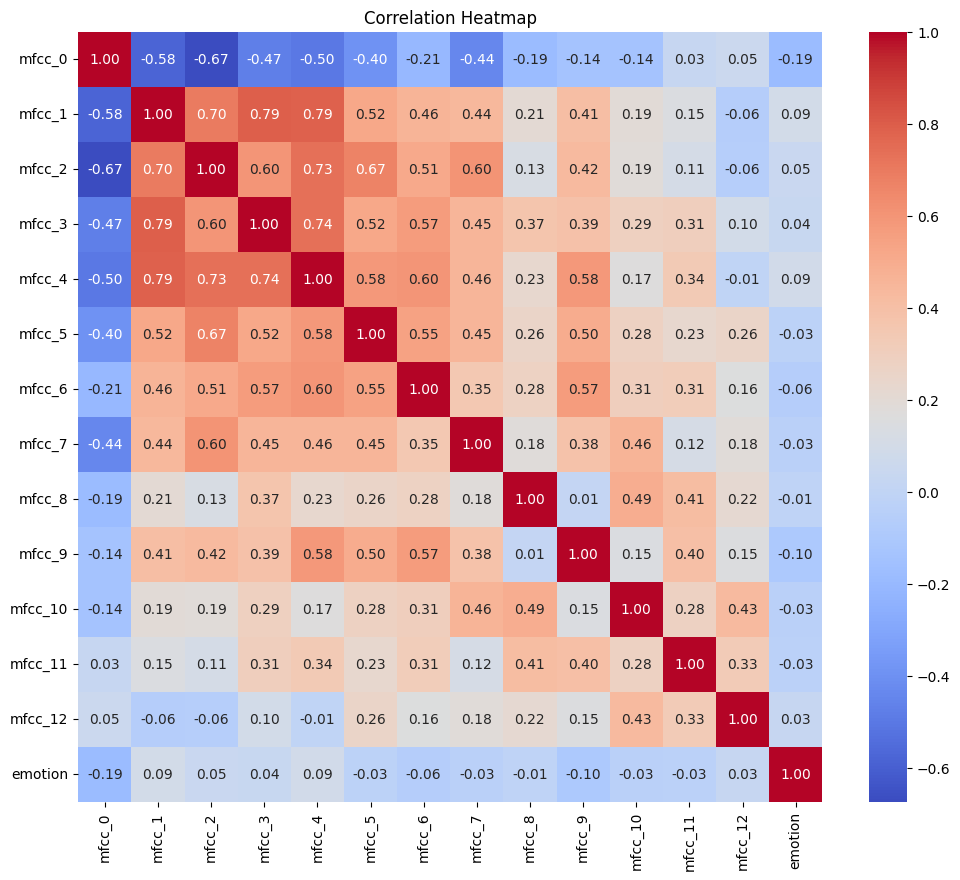

In [24]:
print("\nCorrelation Analysis (Numerical Features):")
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

------
- #### Visualization of Feature Distributions

- how the features are distributed to see if any transformations (like scaling) are needed


Visualizing Feature Distributions:


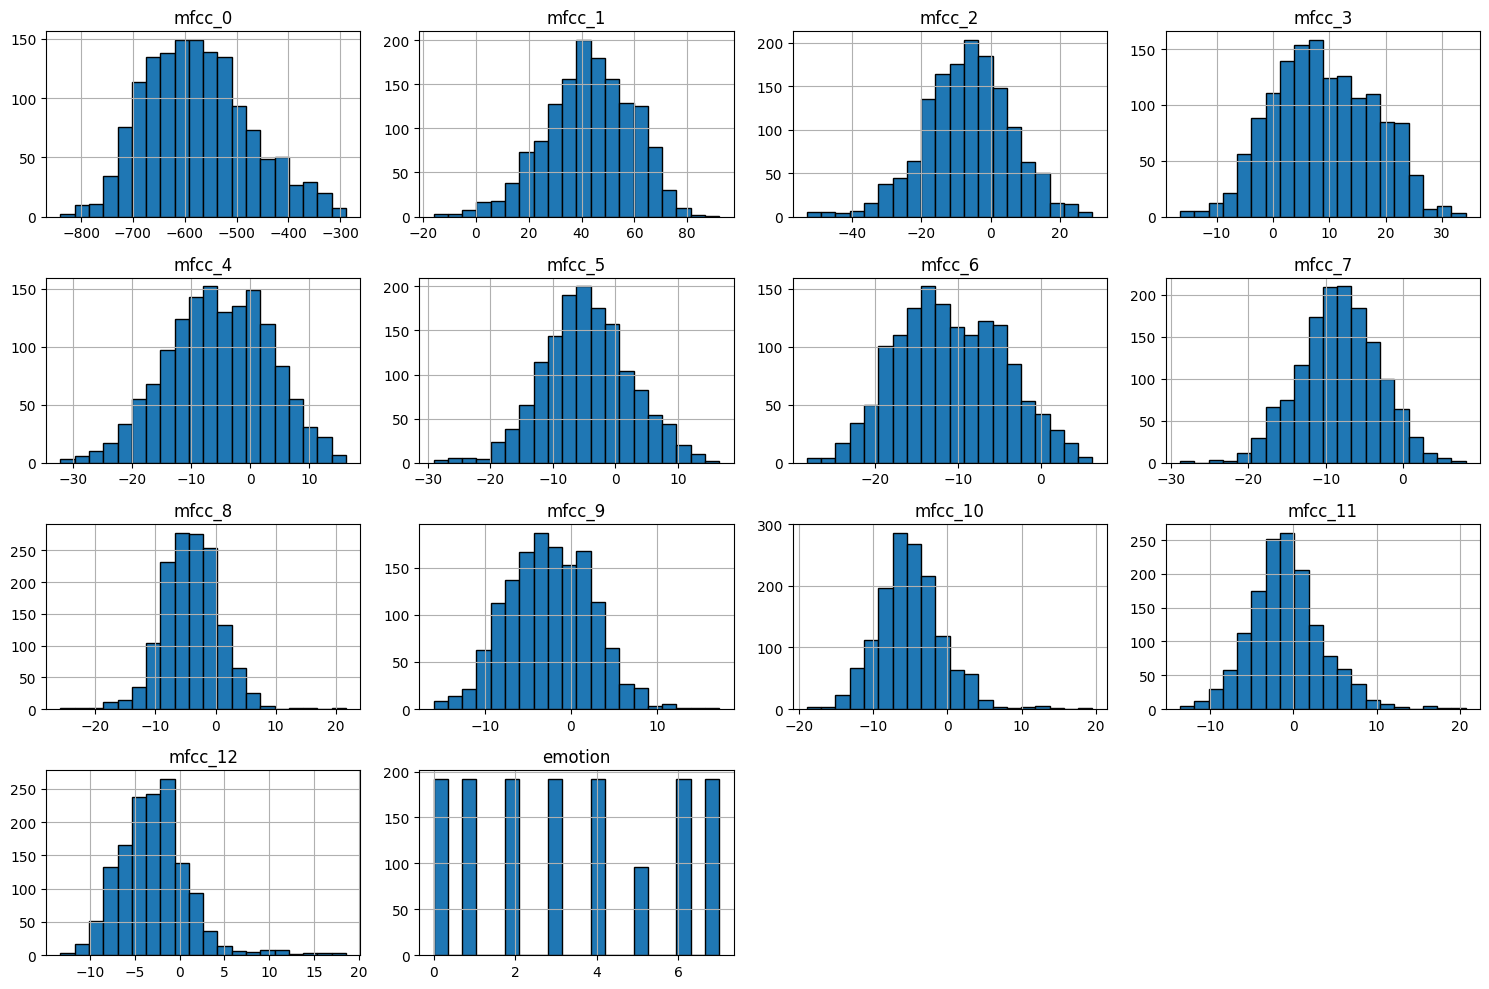

In [25]:
print("\nVisualizing Feature Distributions:")
data.hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

### Visualize distribution of emotions

C:\Users\3ML4Ever\AppData\Local\Temp\ipykernel_17420\2842804524.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


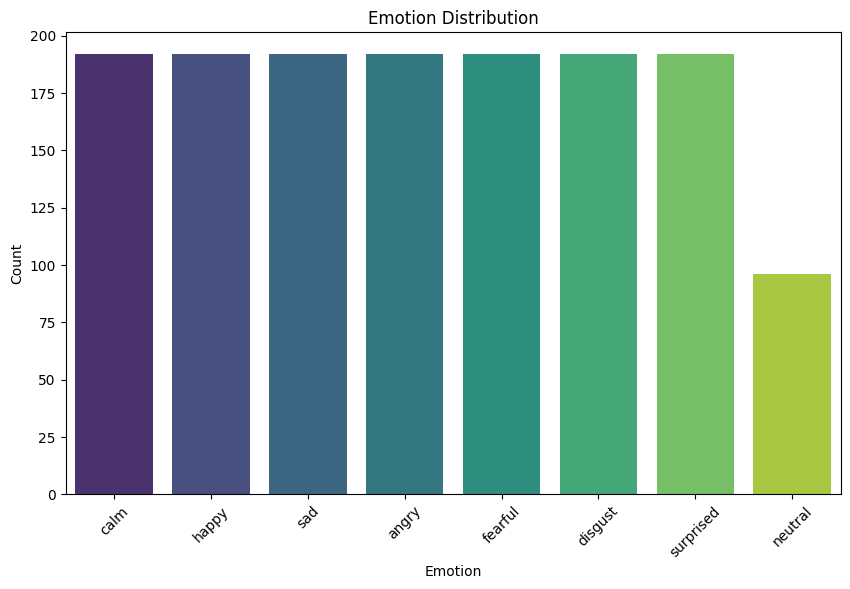

In [26]:
plt.figure(figsize=(10, 6))
emotion_counts = metadata['emotion'].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()